<h1>Potato Disease Classification</h1>

#### By Samrat Mitra (https://github.com/lionelsamrat10/)

Dataset Credit: [https://www.kaggle.com/arjuntejaswi/plant-village](https://www.kaggle.com/arjuntejaswi/plant-village)

There are three type of images, present in the dataset:

1. Potato Leaves with Early Blight disease
2. Normal or Healthy Potato leaves
3. Potato Leaves with Late Blight disease

In this project, our goal is to predict whether an image of a potato leaf, provided by the user is healthy or having early or late blight disease.

## Import necessary modules

In [81]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

## Set all the Constants

In [25]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCH = 50

## Import data (images) into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [26]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


### Exploring all the image classes

In [27]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

### Find the length of the dataset (Here we will length in number of batches)

In [28]:
len(dataset) # Actual length 68 * 32 because images are in a batch of 32

68

### Displaying the image properties

In [36]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 2 1 0 0 0 1 0 1 0 0 0 2 2 0 0 0 1 0 1 0 0 0 2 0 1 1 0 1 0 1]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

## Visualize some of the images from our dataset

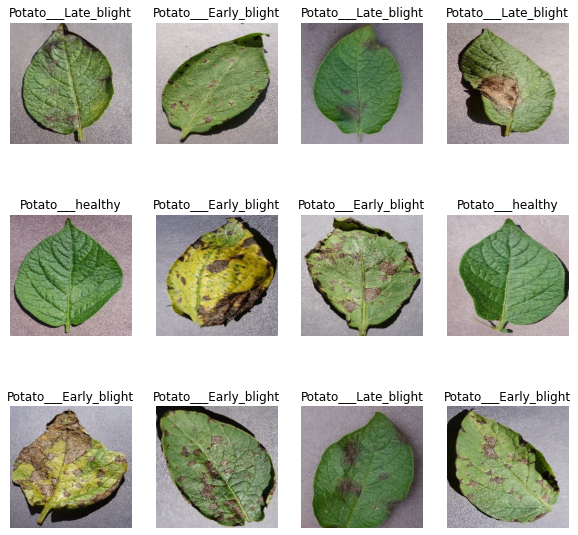

In [29]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8")) # image_batch[0] returns a tensor and using numpy() we are converting it to a numpy array
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

## Function to Split Dataset into Training and Test dataset

Dataset should be bifurcated into 3 subsets, namely:

1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [30]:
train_size= 0.8
len(dataset) * train_size

54.400000000000006

In [31]:
train_ds = dataset.take(54)
len(train_ds)

54

In [32]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [33]:
val_size = 0.1
len(dataset) * val_size

6.800000000000001

In [34]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [35]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [37]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [38]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [40]:
print(len(test_ds)) # It has 8 batches i.e. 8 * 32 = 256

8


In [42]:
print(len(train_ds))

54


In [43]:
print(len(val_ds))

6


## Building Our Model

### Optimize the performance of our training 

Using Caching and Prefetching for the optimization of traing performance of our model

#### Creating a Layer for Resizing and Normalization

Before we feed our images to the network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing them with 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [51]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE) # Read image from disk and cache it into memory
# If CPU or GPU is busy with loading images, the prefetch() will fetch the next batch of images
# We are letting Tensorflow to determine how many batches to prefetch
# The dataset is now optimised for training performance
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

### Resize and rescale the image

In [49]:
# Firstly: Resizing the image to 256 px * 256 px
# Secondly: Rescaling the image from the scale of (0 to 255) to the scale of (0 to 1)
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

### Applying Data Augmentation to our images

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

We will perform different transformation techniques such as Horizontal Flip, Zooming, Changing Contrast of the images, Rotation of the images and create multiple transformed images from our dataset. This will make our model more robust.

In [52]:
data_augmetation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [53]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    # First do Resize and Rescale
    resize_and_rescale,
    # Then perform Data Augmentation
    data_augmetation,
    # The Convolution Layer with 32 layers with (3 * 3) filters and ReLU activation function
    layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = input_shape),
    # The Max Pooling Layer (Reduce the size of the image) with 2 * 2 filter_size
    layers.MaxPooling2D((2, 2)),
    # Add more Convolution and Max Pooling layer
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # Now apply flattening
    layers.Flatten(),
    # Add a Dense layer of 64 Nuerons
    layers.Dense(64, activation='relu'),
    # The output layer will have 3 neurons because we have to make three type of predictions
    # It is using Softmax activation function, which will normalize the probability of the classes
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape = input_shape)

In [54]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [55]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [56]:
history = model.fit(
    train_ds,
    epochs = EPOCH,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 319s 5s/step - loss: 0.9112 - accuracy: 0.4653 - val_loss: 0.8230 - val_accuracy: 0.4792
Epoch 2/50
54/54 [==============================] - 194s 4s/step - loss: 0.7238 - accuracy: 0.6400 - val_loss: 0.5779 - val_accuracy: 0.7500
Epoch 3/50
54/54 [==============================] - 187s 3s/step - loss: 0.5452 - accuracy: 0.7541 - val_loss: 0.3932 - val_accuracy: 0.8542
Epoch 4/50
54/54 [==============================] - 188s 3s/step - loss: 0.4443 - accuracy: 0.8189 - val_loss: 0.3544 - val_accuracy: 0.8750
Epoch 5/50
54/54 [==============================] - 185s 3s/step - loss: 0.3465 - accuracy: 0.8519 - val_loss: 0.3678 - val_accuracy: 0.8177
Epoch 6/50
54/54 [==============================] - 186s 3s/step - loss: 0.2941 - accuracy: 0.8773 - val_loss: 0.2571 - val_accuracy: 0.9115
Epoch 7/50
54/54 [==============================] - 187s 3s/step - loss: 0.2442 - accuracy: 0.9172 - val_loss: 0.1876 - val_accuracy: 0.9427
Epoch 8/50
54

In [57]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 63s 836ms/step - loss: 0.0090 - accuracy: 1.0000


we get 100.00% accuracy for our test dataset. This is considered to be a pretty good accuracy

In [58]:
scores

[0.008969206362962723, 1.0]

Scores is just a list containing loss and accuracy value

In [59]:
history

In [60]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [61]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

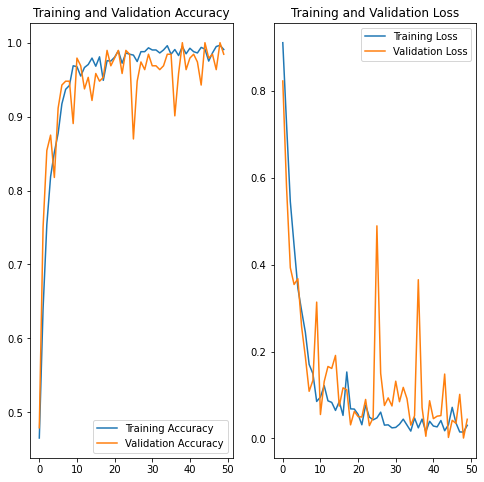

In [73]:
# Accuracy Chart
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCH), acc, label = 'Training Accuracy')
plt.plot(range(EPOCH), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(range(EPOCH), loss, label = 'Training Loss')
plt.plot(range(EPOCH), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
Actual Label:  Potato___Late_blight
Predicted Label Potato___Late_blight


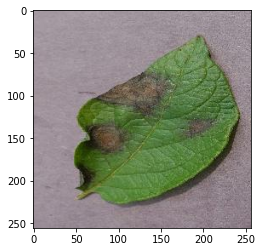

In [89]:
for images_batch, labels_batch in test_ds.take(1):  # We are taking only one batch means 32 images
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]
    
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual Label: ", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted Label", class_names[np.argmax(batch_prediction[0])])

In [90]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

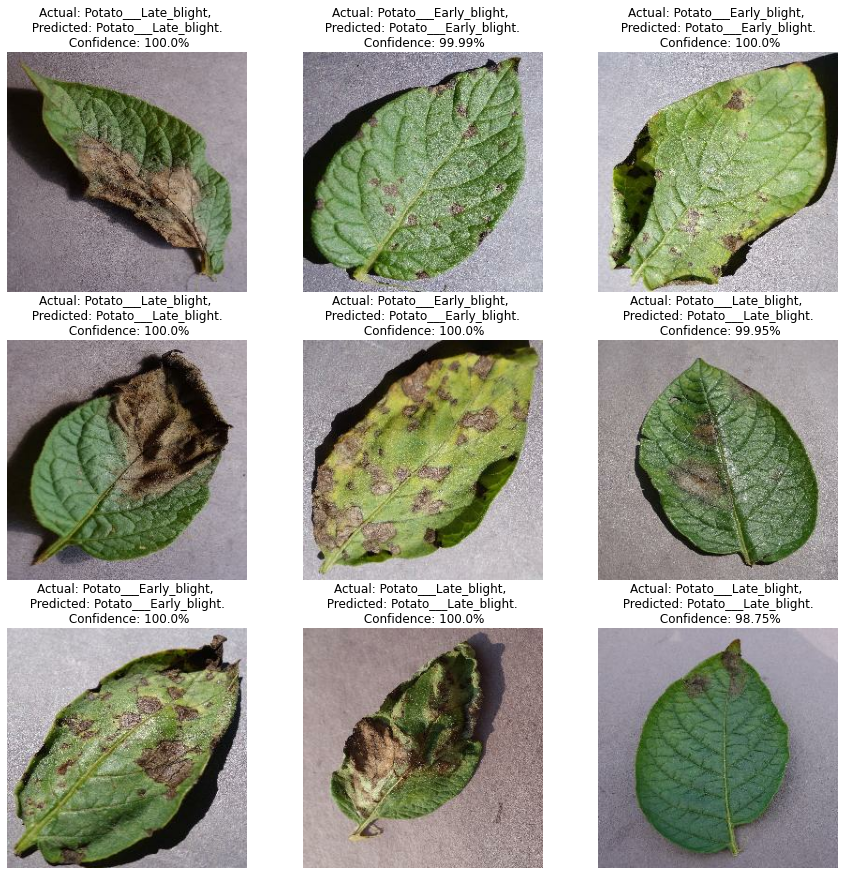

In [100]:
# Create the Plot (Actual vs Prediction)
plt.figure(figsize = (15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}. \n Confidence: {confidence}%")
        
        plt.axis("off")

In [120]:
import os
model_version = max([int(i) for i in os.listdir("../models") + [0]])+1
model.save("../models/{model_version}")

In [118]:
model.save("../potatoes.h5")